# Image Analysis with Python - <font color='teal'>Tutorial Pipeline Section 2</font>

*originally created in 2016*<br>
*updated and converted to a Jupyter notebook in 2017*<br>
*updated and converted to python 3 in 2018*<br>
*by Jonas Hartmann (Gilmour group, EMBL Heidelberg)*<br>
*updated in 2022 by Cheng-Yu Huang*<br>

##  Table of Contents

1. [About this Tutorial](#about)
2. [Initialization](#initialize)
11. [Postprocessing: Removing ROIs at the Image Border](#postpro)
12. [Identifying Cell Edges](#edges)
13. [Extracting Quantitative Measurements](#measure)
14. [Simple Analysis & Visualization](#analysis)
15. [Writing Output to Files](#write)
16. [BONUS - Batch Processing](#batch)

##  About this Tutorial <a id=about></a>

*This tutorial covers the part 2 of the image analysis tutorial*


#### Instructions

- In the section 1 of the Codelab, you performed adaptive thresholding and connected-component analysis of our raw image.

- Here we are going to continue from where we left behind, starting with the segmentation result, we will first clean all the cell patches near the border of the image, and detect the edge of each cells. Then we will perform the statistical analysis to the results.

## Initialization <a id=initialize></a>

In this section we will load the raw image data and our segmentation results, for further processing

In [1]:
# (i) Importing necessary modules and packages

# The numerical arrays manipulation module numpy as np
import numpy as np

# The plotting module matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# The image processing module scipy.ndimage as ndi
import scipy.ndimage as ndi

# Import imread function from skimage.io
from skimage.io import imread

In [2]:
# (ii) Specify the directory path and file name

# Create a string variable with the relative (or absolute) path to your raw image
# and segmentation results. 
img_filepath = r'example_data\example_cells_1.tif'
seg_filepath = r'example_cells_1_seg.tif'

In [3]:
# (iii) Load the raw image and the segmentation results

# Read images
img = imread(img_filepath)
seg = imread(seg_filepath)

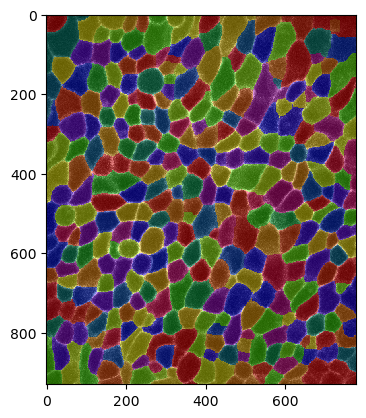

In [4]:
# (iv) Look at the images to confirm that everything worked as intended

# Imshow the raw image
plt.imshow(img, interpolation='none', cmap='gray')
# Overlay the segmentation result, with an alpha value of 0.4
plt.imshow(seg, interpolation='none', cmap='prism', alpha=0.4)

## Postprocessing: Removing ROIs at the Image Border <a id=postpro></a>

#### Background

Since segmentation is never perfect, it often makes sense to explicitely remove artifacts afterwards. For example, one could filter out objects that are too small, have a very strange shape, or very strange intensity values. 

**Warning:** Filtering out objects is equivalent to the *removal of outliers* in data analysis and *should only be done for good reason and with caution!*

As an example of postprocessing, we will now filter out a particular group of problematic cells: those that are being cut off at the image border.

#### <font color='teal'> Exercise </font>

Iterate through all the ROIs in your segmentation and remove those touching the image border.

Follow the instructions in the comments below. Note that the instructions will get a little less specific from here on, so you need to figure out how to approach a problem yourself.

In [5]:
# (i) Create an image border mask

# We need some way to check if a cell is at the border. For this, we generate a 'mask' of the image border,
# i.e. a Boolean array of the same size as the image where only the border pixels are set to `1` and all 
# others to `0`, like this:
#   1 1 1 1 1
#   1 0 0 0 1
#   1 0 0 0 1
#   1 0 0 0 1
#   1 1 1 1 1
# There are multiple ways of generating this mask, for example by erosion or by array indexing.
# It is up to you to find a way to do it. (Hint: one of the the easiest ways to do this is via scipy.ndimage.binary_dilation.
# check the parameter "border_value")

border_mask = np.zeros(seg.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

In [6]:
# (ii) 'Delete' the cells at the border

# 1) Find the cell ROIs that are crossing the border of the image

# Find the border ROI IDs, by first multiply the border_mask by the segmentation mask
border_mask_rois = border_mask * seg

# Then get an array of ROI IDs by finding the unique elements in the array
border_roi_ids = np.unique(border_mask_rois)
border_roi_ids

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  16,
        20,  22,  46,  52,  65,  78,  95, 106, 107, 125, 136, 172, 180,
       184, 198, 210, 222, 225, 244, 251, 257, 270, 275, 287, 297, 302,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327,
       328, 329], dtype=uint16)

In [7]:
# 2) 'Delete' ROIs by their IDs

# Create a copy of the segmentation with np.copy()
clean_seg = np.copy(seg)

# Iterate over ROI IDs on the border and set the those ROIs to background (0)
for roi_id in border_roi_ids:
    
    # Create a mask that contains only the 'current' ROI of the iteration
    roi_mask = seg == roi_id
    
    # Set the position of that roi_mask to background (zero) in the clean_seg
    clean_seg[roi_mask] = 0

In [8]:
# OPTIONAL: re-label the remaining cells to keep the numbering consistent from 1 to N (with 0 as background).
# Hint: Use python function <enumerate>

# Use enumerate
for new_ID, cell_ID in enumerate(np.unique(clean_seg)[1:]):  # The [1:] excludes 0 from the list (background)!
    clean_seg[clean_seg==cell_ID] = new_ID+1                  # The same here for the +1

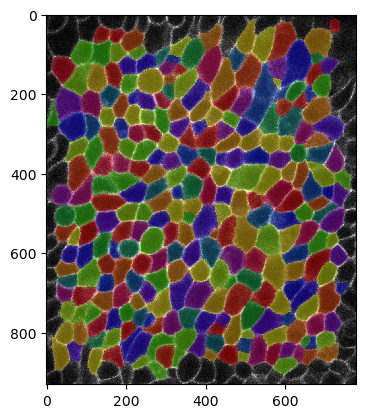

In [9]:
# (iii) Visualize the result

# Show the result as transparent overlay over the raw or smoothed image. 
# Here you have to combine alpha (to make cells transparent) and 'np.ma.array'
# (to hide empty space where the border cells were deleted).

# Create mask by 'np.ma.array'
clean_seg_mask = np.ma.array(clean_seg, mask=clean_seg==0)

# Show image
plt.imshow(img, interpolation='none', cmap='gray')
plt.imshow(clean_seg_mask, interpolation='none', cmap='prism', alpha=0.4)
plt.show()

## Identifying Cell Edges <a id=edges></a>

#### Background

With the final segmentation in hand, we can now start to think about measurements and data analysis. However, to extract interesting measurements from our cells, the segmentation on its own is often not enough: additional masks that identify sub-regions for each cell allow more precise and more biologically relevant measurements.

The most useful example of this is an additional mask that identifies only the edge pixels of each cell. This is useful for a number of purposes, including:

- Edge intensity is a good measure of membrane intensity, which is often a desired readout.
- The intensity profile along the edge may contain information on cell polarity.
- The length of the edge (relative to the cell area) is an informative feature about the cell shape. 
- Showing colored edges is a nice way of visualizing cell segmentations.

There are many ways of identifying edge pixels in a fully labeled segmentation. Here, we will use a simple and relatively fast method based on erosion.

#### <font color='teal'> Exercise </font>

Create a labeled mask of cell edges by following these steps:


- Create an array of the same size and data type as the segmentation but filled with only zeros
    - This will be your final cell edge mask; you gradually add cell edges as you iterate over cells
    

- *For each cell...*
    - Erode the cell's mask by 1 pixel
    - Using the eroded mask and the original mask, create a new mask of only the cell's edge pixels
    - Add the cell's edge pixels into the empty image generated above, labeling them with the cell's original ID number


Follow the instructions in the comments below.

In [23]:
# (i) Create an array of the same size and data type as the segmentation but filled with only zeros

# Hint: use np.zeros_like()
edges = np.zeros_like(clean_seg)

In [11]:
# (ii) Iterate over the ROI IDs
for roi_id in np.unique(clean_seg)[1:]:
    
    # (iii) Erode the ROI's mask by 1 pixel
    # Hint: 'ndi.binary_erode'
    roi_mask = clean_seg == roi_id
    eroded_roi_mask = ndi.binary_erosion(roi_mask, iterations=1) # Increase iterations to make boundary wider!
    
    # (iv) Create the cell edge mask
    # Hint: 'np.logical_xor'
    edge_mask = np.logical_xor(roi_mask, eroded_roi_mask)
    
    # (v) Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    edges[edge_mask] = roi_id

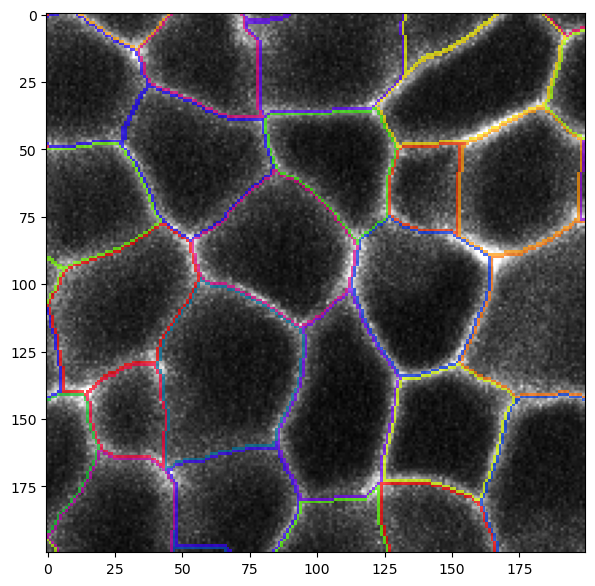

In [12]:
# (vi) Visualize the result

# Note: Because the lines are so thin (1pxl wide), they may not be displayed correctly in small figures.
#       You can 'zoom in' by showing a sub-region of the image which is then rendered bigger. You can
#       also go back to the edge identification code and make the edges multiple pixels wide (but keep 
#       in mind that this will have an effect on your quantification results!).

plt.figure(figsize=(7,7))
edges_mask = np.ma.array(edges, mask=edges==0)
plt.imshow(img[300:500, 300:500], cmap='gray')
plt.imshow(edges_mask[300:500, 300:500], interpolation='none', cmap='prism', alpha = 0.7)
plt.show()

## Extracting Quantitative Measurements <a id=measure></a>

#### Background

The ultimate goal of image segmentation is of course the extraction of quantitative measurements, in this case on a single-cell level. Measures of interest can be based on intensity (in different channels) or on the size and shape of the cells.

To exemplify how different properties of cells can be measured, we will extract the following:

- Cell ID (so all other measurements can be traced back to the cell that was measured)
- Mean intensity of each cell
- Mean intensity at the membrane of each cell
- The cell area, i.e. the number of pixels that make up the cell
- The cell outline length, i.e. the number of pixels that make up the cell edge

*Note: It makes sense to use smoothed/filtered/background-subtracted images for segmentation. When it comes to measurements, however, it's best to get back to the raw data!*

#### <font color='teal'>Exercise</font>

Extract the measurements listed above for each cell and collect them in a dictionary.

Note: The ideal data structure for data like this is the `DataFrame` offered by the module `Pandas`. However, for the sake of simplicity, we will here stick with a dictionary of lists.

Follow the instructions in the comments below.

In [13]:
# (i) Create a dictionary that contains a key-value pairing for each measurement

# The keys should be strings describing the type of measurement (e.g. 'intensity_mean') and 
# the values should be empty lists. These empty lists will be filled with the results of the
# measurements.

results = {"cell_id"      : [],
           "int_mean"     : [],
           "int_mem_mean" : [],
           "cell_area"    : [],
           "cell_edge"    : []}

# Solution note: the spacing between the strings and colons doesn't matter for the code's
# execution. It is used solely to make the code more readable!

In [14]:
# (ii) Record the measurements for each cell

# Iterate over the segmented cells ('np.unique').
# Inside the loop, create a mask for the current cell and use it to extract the measurements listed above. 
# Add them to the appropriate list in the dictionary using the 'append' method.
# Hint: Remember that you can get out all the values within a masked area by indexing the image 
#       with the mask. For example, 'np.mean(image[cell_mask])' will return the mean of all the 
#       intensity values of 'image' that are masked by 'cell_mask'!

# Get cell ids with np.unique
cell_ids = np.unique(clean_seg)

# Iterate over cell IDs
for cell_id in cell_ids[1:]:

    # Mask the current cell and cell edge
    cell_mask = clean_seg==cell_id
    edge_mask = edges==cell_id
    
    # Get the measurements
    results["cell_id"].append(cell_id)
    results["int_mean"].append(np.mean(img[cell_mask]))
    results["int_mem_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

In [15]:
# (iii) Import Pandas as pd, and make the dictionary a pandas object

# Import pandas as pd
import pandas as pd

# Make results as a pandas dataframe ('pd.DataFrame()')
df = pd.DataFrame(results)

# Show the pandas dataframe
df

,cell_id,int_mean,int_mem_mean,cell_area,cell_edge
0,1,30.748336,34.980198,751,101
1,2,45.651852,89.857143,1350,126
2,3,55.141110,117.098214,1063,112
3,4,45.191325,92.089844,4265,256
4,5,43.142083,104.479290,2400,169
...,...,...,...,...,...
271,272,46.785503,68.320000,676,100
272,273,55.931418,100.636364,1079,110
273,274,47.525161,93.147887,1868,142
274,275,66.494987,97.494382,798,89


In [16]:
# You can also sort df by values
df.sort_values(by = "cell_area", ascending=False)

,cell_id,int_mean,int_mem_mean,cell_area,cell_edge
44,45,61.761219,126.138329,6529,347
19,20,47.678191,109.020270,5814,296
116,117,65.614921,150.930769,4812,260
164,165,45.455373,90.153543,4392,254
191,192,47.894504,115.945148,4294,237
...,...,...,...,...,...
254,255,64.597907,89.027273,669,110
18,19,58.257749,75.320388,613,103
162,163,74.189831,114.058140,590,86
250,251,66.971930,100.705128,570,78


In [17]:
# (iv) You can write pandas dataframe as csv for data analysis in other softwares
df.to_csv("measurement.csv")

# To Read:
# df1 = pd.read_csv('measurement.csv')

## Simple Analysis & Visualisation <a id=analysis></a>

#### Background

By extracting quantitative measurements from an image we cross over from 'image analysis' to 'data analysis'. 

This section briefly explains how to do basic data analysis and plotting, including boxplots, scatterplots and linear fits. It also showcases how to map data back onto the image, creating an "image-based heatmap".

#### <font color='teal'>Exercise</font>

Analyze and plot the extracted data in a variety of ways.

Follow the instructions in the comments below.

In [18]:
# (i) Familiarize yourself with the data structure of the results dict and summarize the results

# 1) Try to print the mean of mean intensity of all cells
mean_int_mean = np.mean(df['int_mean'])
print(f'Mean of int_mean is {mean_int_mean}')

Mean of int_mean is 57.0693036725934


In [19]:
# 2) Try df.describe() to get all the necessary stats
# Bonus: can you make all of the numbers round up to 2 decimal places? (Try Google)
pd.options.display.float_format = "{:.2f}".format
df.describe()

,cell_id,int_mean,int_mem_mean,cell_area,cell_edge
count,276.00,276.00,276.00,276.00,276.00
mean,138.50,57.07,119.78,2106.34,162.70
std,79.82,10.86,24.35,919.42,38.81
min,1.00,30.75,34.98,433.00,78.00
25%,69.75,49.32,101.62,1539.00,137.00
50%,138.50,56.17,119.89,2050.00,160.00
75%,207.25,63.06,135.42,2588.50,185.25
max,276.00,98.83,185.31,6529.00,347.00


Text(0.5, 1.0, 'Histogram of Cell Area Distribution')

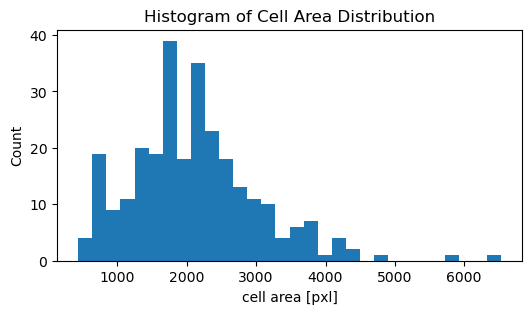

In [20]:
# (ii)-1 Create a histogram showing the distribution of cell surface area in pixels 

# Use the function 'plt.hist'. Change the "bins" parameter of the function to see the more detailed 
# trend of the data. What do you observe?

plt.figure(figsize=(6,3))
num_bins = 30
plt.hist(df['cell_area'], bins = num_bins)
plt.xlabel('cell area [pxl]')
plt.ylabel('Count')
plt.title('Histogram of Cell Area Distribution')

C:\Users\OWNER\AppData\Local\Temp\ipykernel_6176\575563039.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['int_mean'], df['int_mem_mean']],


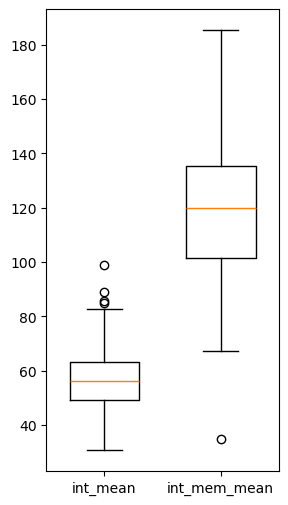

In [21]:
# (ii)-2 Create a box plot showing the mean cell and mean membrane intensities for both channels. 

# Use the function 'plt.boxplot'. Use the 'label' keyword of 'plt.boxplot' to label the x axis with 
# the corresponding key names. Feel free to play around with the various options of the boxplot 
# function to make your plot look nicer. Remember that you can first call 'plt.figure' to adjust 
# settings such as the size of the plot.

### YOUR CODE HERE!

plt.figure(figsize=(3,6))
plt.boxplot([df['int_mean'], df['int_mem_mean']], 
            labels=['int_mean', 'int_mem_mean'],
           widths=0.6)
plt.show()

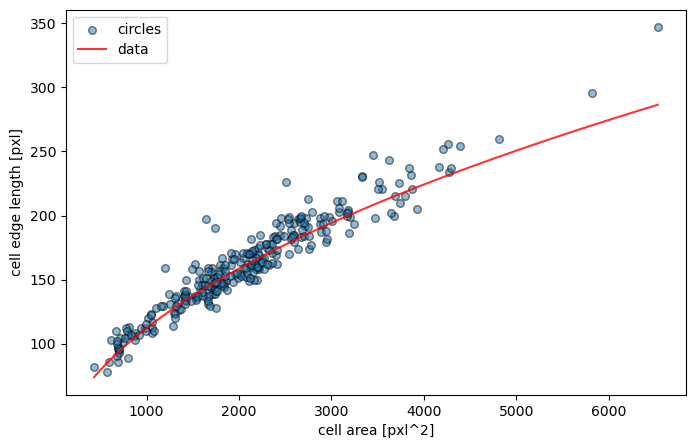

In [22]:
# (iii) Create a scatter plot of cell outline length over cell area

# Use the function 'plt.scatter' for this. Be sure to properly label the 
# plot using 'plt.xlabel' and 'plt.ylabel'.
# Note: it is a good idea to make the marker (the data point) more transparent so that
# where you found the plot less transparent it means there are data points overlapping.

plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["cell_edge"],
           edgecolor='k', s=30, alpha=0.5)
plt.xlabel('cell area [pxl^2]')
plt.ylabel('cell edge length [pxl]')

# BONUS: Do you understand why you are seeing the pattern this produces? 
###
# ->> The curve reflects how circumference scales with area!

# Can you generate a 'null model' curve that assumes all cells to be circular?
cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num = 100)
circle_circumference = 2*np.pi*np.sqrt(cell_area_range/ np.pi)
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['circles', 'data'], loc=2, fontsize=10)

# What is the result? Do you notice something odd about it? What could be the reason for
# this and how could it be fixed?
###
# ->> In general, the cells don't deviate all that much from the circular case.
# ->> Strangely, some cells have a smaller outline than the circumference of a circle
#     of equivalent area. This is mathematically impossible.
# ->> A possible reason could be that the measures are taken in pixels, which leads
#     to a so-called discretization error. It could be fixed by "meshing" the cell
#     outline and interpolating a more accurate measurement of circumference.

In [ ]:
# (iv) Perform a linear fit of membrane intensity over cell area

# Use the function 'linregress' from the module 'scipy.stats'. Be sure to read the docs to
# understand the output of this function. Print the output.

# Compute linear fit
from scipy.stats import linregress
linfit = linregress(df["cell_area"], df["int_mem_mean"])

# Print all the results
linprops = ['slope', 'intercept','rvalue','pvalue', 'stderr'] #linfit properties
for index,prop in enumerate(linprops):
    print( prop, '\t', '{:4.2e}'.format(linfit[index]) )

In [ ]:
# (v) Think about the result

# Note that the fit seems to return a highly significant p-value but a very low correlation 
# coefficient (r-value). Based on prior knowledge, we would not expect a linear correlation of 
# this sort to be present in our data. 
#
# This should prompt several questions:
#   1) What does this p-value actually mean? Check the docs of 'linregress'!
###
#       ->> This p-value only means that, given a linear fit through this data, the slope of the
#           fit is very unlikely to be zero. However, it does not make a statement on whether or
#           not it makes sense to use a linear fit in the first place. Looking at the scatterplot
#           below or at the correlation coefficient r, it is clear that a linear fit on this data
#           is not meaningful.
#       ->> Note also: With single-cell approaches, we quickly get to a large number of data points. 
#           This makes hypothesis testing in general less useful, as p-values tend to become very
#           small even if the null hypothesis holds. It makes sense to instead report effect sizes.
#           This is a tricky topic but well worth reading up on.
#
#   2) Could there be artifacts in our segmentation that bias this analysis?
###
#       ->> Oversegmentation is an important source of bias here. If a cell is oversegmented,
#           it will be considered as two or three cells. These will naturally have a lower
#           cell area and will naturally have a lower membrane intensity because some of their
#           edges are actually not on membranes. In other words, they will fall into the bottom
#           left of the plot, distorting the data.
#
# In general, it's always good to be very careful when doing any kind of data analysis. Make sure you 
# understand the functions you are using and always check for possible errors or sources of bias!

In [ ]:
# (vi) Overlay the linear fit onto a scatter plot

# Recall that a linear function is defined by `y = slope * x + intercept`.

# To define the line you'd like to plot, you need two values of x (the starting point and
# and the end point of the line). What values of x make sense? Can you get them automatically?
#   ->> The max and min values in the data are a good choice.
x_vals = [min(df["cell_area"]), max(df["cell_area"])]

# When you have the x-values for the starting point and end point, get the corresponding y 
# values from the fit through the equation above.
y_vals = [linfit[0] * x_vals[0] + linfit[1], linfit[0] * x_vals[1] + linfit[1]]

# Plot the line with 'plt.plot'. Adjust the line's properties so it is well visible.
# Note: Remember that you have to create the scatterplot before plotting the line so that
#       the line will be placed on top of the scatterplot.
plt.figure(figsize=(8,5))
plt.scatter(df["cell_area"], df["int_mem_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)

# Use 'plt.legend' to add information about the line to the plot.
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)

# Label the plot and finally show it with 'plt.show'.
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")
plt.show()

In [ ]:
# (vii) Map the cell area back onto the image as a 'heatmap'

# Scale the cell area data to 8bit so that it can be used as pixel intensity values.
areas_8bit = np.array(df["cell_area"]) / max(df["cell_area"]) * 255

# Initialize a new image array, with dtype as uint8
area_map = np.zeros_like(clean_seg, dtype = np.uint8)

# Iterate over the segmented cells
for index, cell_id in enumerate(df["cell_id"]):
    
    # Extract cell mask
    cell_mask = clean_seg == cell_id
    
    # Add cells to the area map
    area_map[cell_mask] = areas_8bit[index]
    
# BONUS: See if you can exclude outliers to make the color mapping more informative!
    
# Visulize the results:
# Create the mask array
area_map_mask = np.ma.array(area_map, mask = area_map == 0)
plt.imshow(img, interpolation='none', cmap='gray')
plt.imshow(area_map_mask, interpolation='none', cmap='viridis', alpha=0.6)

In [ ]:
# (viii) Write a figure to a png or pdf

# Recreate the scatter plot from above (with or without the regression line), then save the figure
# as a png using 'plt.savefig'. Alternatively, you can also save it to a pdf, which will create a
# vector graphic that can be imported into programs like Adobe Illustrator.

plt.scatter(df["cell_area"], df["int_mem_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")

# Save as png and pdf
plt.savefig('example_cells_1_scatterFit.png')
plt.savefig('example_cells_1_scatterFit.pdf')
plt.clf()  # Clear the figure buffer

## \**BONUS\** >> Batch Processing: See tutorial section 3 <a id=batch></a>

## <font color='teal'>*Congratulations! You have completed the tutorial!*</font>

**We hope you enjoyed the ride and learned a lot!**

### Concluding Remarks

It's important to remember that the phrase ***"Use it or loose it!"*** fully applies for the skills taught in this tutorial.

If you now just go back to the lab and don't touch python or image analysis for the next half year, most of the things you have learned here will be lost.

So, what can you do?


- If possible, start applying what you have learned to your own work right away


- Even if your current work doesn't absolutely *need* coding / image analysis (which to be honest is hard to believe! ;p), you can still use it at least to make some nice plots!


- Another very good approach is to find yourself an interesting little side project you can play around with

***We wish you the best of luck for all your coding endeavors!***